# Introduction

In this notebook, the contacts TCRs make with Class I pMHC molecules are mapped to the MHC. These contact postions are visualised in several different ways.

In [1]:
import glob
import os
import itertools
from collections import OrderedDict, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from python_pdb.parsers import parse_pdb_to_pandas

from tcr_pmhc_structure_tools.imgt_numbering import assign_cdr_number

In [2]:
STCRDAB_PATH = '../data/STCRDab'

In [3]:
stcrdab_summary = pd.read_csv(os.path.join(STCRDAB_PATH, 'db_summary.dat'), delimiter='\t')

selected_stcrdab = stcrdab_summary.copy()

# Resolution better than 3.50 Å
selected_stcrdab['resolution'] = pd.to_numeric(selected_stcrdab['resolution'], errors='coerce')
selected_stcrdab = selected_stcrdab.query("resolution < 3.50")

# alpha-beta TCRs
selected_stcrdab = selected_stcrdab.query("TCRtype == 'abTCR'")

# MHC class I
selected_stcrdab = selected_stcrdab.query("mhc_type == 'MH1'")

# peptide antigen
selected_stcrdab = selected_stcrdab.query("antigen_type == 'peptide'")

# General clean: drop columns that don't contain anything useful
selected_stcrdab = selected_stcrdab.loc[:, selected_stcrdab.nunique() > 1]
selected_stcrdab = selected_stcrdab.dropna(axis=1, how='all')

# Reset Index
selected_stcrdab = selected_stcrdab.reset_index(drop=True)

selected_stcrdab

,pdb,Bchain,Achain,antigen_chain,antigen_name,mhc_chain1,mhc_chain2,docking_angle,beta_subgroup,alpha_subgroup,...,alpha_organism,antigen_organism,mhc_chain1_organism,mhc_chain2_organism,authors,resolution,method,r_free,r_factor,engineered
0,7rk7,E,D,C,tyrosinase peptide,A,B,81.339,TRBV10,TRAV4,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Singh, N.K., Davancaze, L.M., Arbuiso, A., Wei...",2.54,X-RAY DIFFRACTION,0.255,0.211,True
1,2ak4,E,D,C,ebv peptide lpeplpqgqltay,A,B,71.108,TRBV6,TRAV19,...,homo sapiens,NaN,homo sapiens,homo sapiens,"Tynan, F.E., Burrows, S.R., Buckle, A.M., Clem...",2.50,X-RAY DIFFRACTION,0.278,0.246,True
2,7nme,E,D,C,gln-leu-pro-arg-leu-phe-pro-leu-leu,A,B,36.100,TRBV7,TRAV5,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Sewell, A.K., Cole, D.K., Wal...",2.20,X-RAY DIFFRACTION,0.274,0.215,True
3,7pbe,J,I,H,spike protein s1,F,G,49.843,TRBV7,TRAV12,...,homo sapiens,severe acute respiratory syndrome coronavirus2,homo sapiens,homo sapiens,"Rizkallah, P.J., Sewell, A.K., Wall, A., Fulle...",3.00,X-RAY DIFFRACTION,0.296,0.228,True
4,5wkh,J,I,H,gts3 peptide,F,G,39.564,TRBV11,TRAV30,...,homo sapiens,dengue virus 3,homo sapiens,homo sapiens,"Gras, S., Rossjohn, J.",3.20,X-RAY DIFFRACTION,0.246,0.177,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,3mv9,E,D,C,hpvg peptide from epstein-barr nuclear antigen 1,A,B,41.382,TRBV9,TRAV20,...,homo sapiens,NaN,homo sapiens,homo sapiens,"Gras, S., Chen, Z., Miles, J.J., Liu, Y.C., Be...",2.70,X-RAY DIFFRACTION,0.331,0.234,True
281,6q3s,E,D,C,ser-leu-leu-met-trp-ile-thr-gln-val,A,B,67.059,TRBV6,TRAV21,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Meijers, R., Anjanappa, R., Springer, S., Garc...",2.50,X-RAY DIFFRACTION,0.273,0.229,True
282,5men,E,D,C,ile-leu-ala-lys-phe-leu-his-trp-leu,A,B,40.823,TRBV6,TRAV22,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Lloyd, A., Crowther, M., Cole...",2.81,X-RAY DIFFRACTION,0.272,0.189,True
283,3vxu,J,I,H,10-mer peptide from protein nef,F,G,NaN,TRBV27,TRAV12,...,homo sapiens,human immunodeficiency virus 1,homo sapiens,homo sapiens,"Shimizu, A., Fukai, S., Yamagata, A., Iwamoto, A.",2.70,X-RAY DIFFRACTION,0.323,0.272,True


# Compute Contacts

Compute the contacts between the TCR CDR loops and the pMHC.

In [4]:
CUTOFF_DISTANCE = 5

contacts = []

for _, row in selected_stcrdab.iterrows():
    path = os.path.join(STCRDAB_PATH, 'imgt', f'{row.pdb}.pdb')
    
    with open(path, 'r') as fh:
        df = parse_pdb_to_pandas(fh.read())
    
    chain_annotations = {}
    chain_annotations[row.Achain] = 'alpha_chain'
    chain_annotations[row.Bchain] = 'beta_chain'
    chain_annotations[row.antigen_chain] = 'antigen_chain'
    chain_annotations[row.mhc_chain1] = 'mhc_chain'
    
    df['chain_type'] = df['chain_id'].map(lambda id_: chain_annotations[id_] if id_ in chain_annotations else None)
    df['cdr'] = df['residue_seq_id'].map(assign_cdr_number)
    
    mhc_interface_df = df.query("chain_type == 'mhc_chain' and residue_seq_id < 1090")
    tcr_cdrs_df = df.query("(chain_type == 'alpha_chain' or chain_type == 'beta_chain') and cdr.notnull()") 
    
    interface = tcr_cdrs_df.merge(mhc_interface_df, how='cross', suffixes=('_tcr', '_mhc'))
    
    interface['distance'] = np.sqrt(np.square(interface['pos_x_tcr'] - interface['pos_x_mhc'])
                                    + np.square(interface['pos_y_tcr'] - interface['pos_y_mhc'])
                                    + np.square(interface['pos_z_tcr'] - interface['pos_z_mhc']))

    c = interface.query('distance < @CUTOFF_DISTANCE').copy()
    c['path'] = path
    
    contacts.append(c)

contacts = pd.concat(contacts)
contacts

,record_type_tcr,atom_number_tcr,atom_name_tcr,alt_loc_tcr,residue_name_tcr,chain_id_tcr,residue_seq_id_tcr,residue_insert_code_tcr,pos_x_tcr,pos_y_tcr,...,pos_y_mhc,pos_z_mhc,occupancy_mhc,b_factor_mhc,element_mhc,charge_mhc,chain_type_mhc,cdr_mhc,distance,path
46127,ATOM,287,CB,None,ARG,E,37,None,-9.824,-28.688,...,-29.354,-28.052,1.0,85.56,N,None,mhc_chain,NaN,4.994149,../data/STCRDab/imgt/7rk7.pdb
47594,ATOM,288,CG,None,ARG,E,37,None,-8.601,-27.785,...,-29.437,-29.377,1.0,99.22,C,None,mhc_chain,NaN,4.284034,../data/STCRDab/imgt/7rk7.pdb
47595,ATOM,288,CG,None,ARG,E,37,None,-8.601,-27.785,...,-28.442,-30.105,1.0,111.19,O,None,mhc_chain,NaN,4.269574,../data/STCRDab/imgt/7rk7.pdb
47596,ATOM,288,CG,None,ARG,E,37,None,-8.601,-27.785,...,-29.354,-28.052,1.0,85.56,N,None,mhc_chain,NaN,4.041411,../data/STCRDab/imgt/7rk7.pdb
47624,ATOM,288,CG,None,ARG,E,37,None,-8.601,-27.785,...,-26.516,-28.687,1.0,71.32,N,None,mhc_chain,NaN,4.397017,../data/STCRDab/imgt/7rk7.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464737,ATOM,2840,NH1,None,ARG,D,115,None,34.196,-6.464,...,-8.470,29.866,1.0,31.69,N,None,mhc_chain,2.0,4.581176,../data/STCRDab/imgt/4jff.pdb
466203,ATOM,2841,NH2,None,ARG,D,115,None,34.779,-7.728,...,-6.880,28.238,1.0,29.24,N,None,mhc_chain,2.0,4.852275,../data/STCRDab/imgt/4jff.pdb
466204,ATOM,2841,NH2,None,ARG,D,115,None,34.779,-7.728,...,-7.968,28.670,1.0,30.85,C,None,mhc_chain,2.0,4.029620,../data/STCRDab/imgt/4jff.pdb
466205,ATOM,2841,NH2,None,ARG,D,115,None,34.779,-7.728,...,-8.550,27.915,1.0,33.82,N,None,mhc_chain,2.0,3.997626,../data/STCRDab/imgt/4jff.pdb


In [5]:
contacts['pdb_id'] = contacts['path'].map(lambda path: path.split('/')[-1].split('.')[0])

In [6]:
contacts['resi_mhc'] = contacts['residue_seq_id_mhc'].apply(str) + contacts['residue_insert_code_mhc'].fillna('')
contacts['resi_tcr'] = contacts['residue_seq_id_tcr'].apply(str) + contacts['residue_insert_code_tcr'].fillna('')

In [7]:
contacts['cdr_name'] = 'CDR' \
    + contacts['cdr_tcr'].apply(int).apply(str) \
    + contacts['chain_type_tcr'].map(lambda chain_type: chain_type.split('_')[0])

# Visualise the Contacts

/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


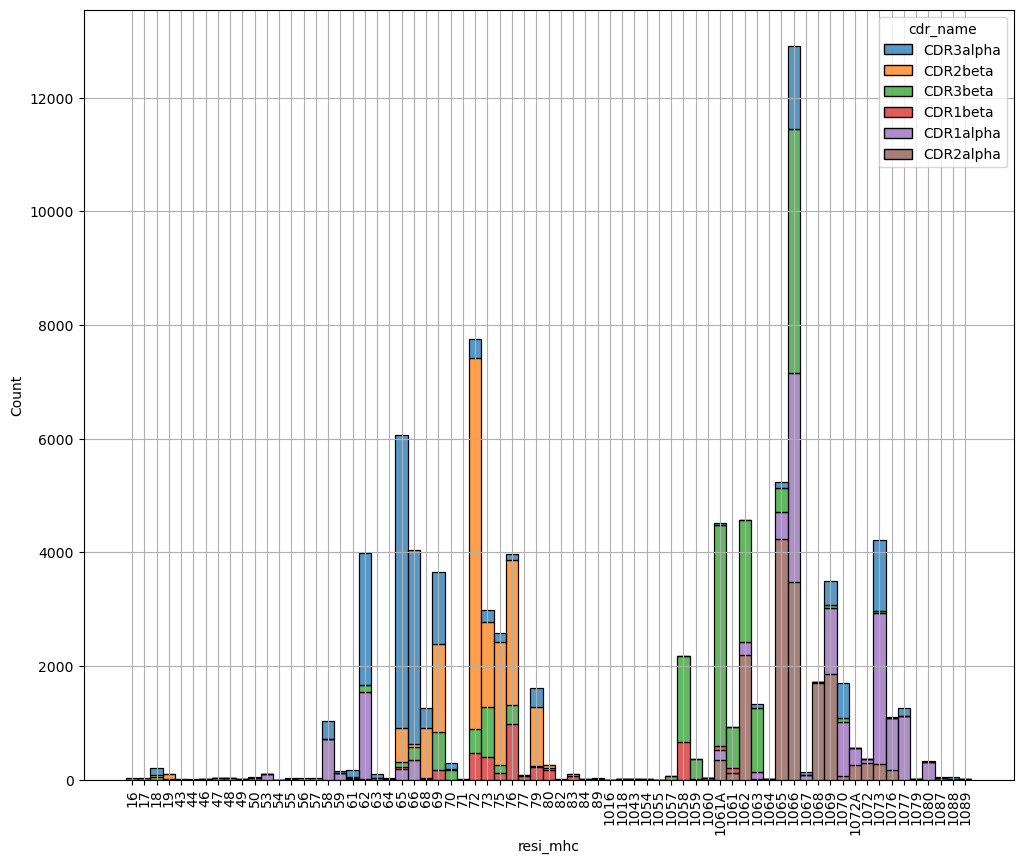

In [8]:
plt.figure(figsize=(12, 10))

sns.histplot(contacts.sort_values('residue_seq_id_mhc'), x='resi_mhc', hue='cdr_name', multiple='stack')
plt.xticks(rotation=90)
plt.grid()
print()

In [9]:
mhc_labels = contacts[['residue_seq_id_mhc', 'residue_insert_code_mhc', 'resi_mhc']].fillna('').sort_values(['residue_seq_id_mhc', 'residue_insert_code_mhc'])['resi_mhc'].unique().tolist()
tcr_labels = contacts[['residue_seq_id_tcr', 'residue_insert_code_tcr', 'resi_tcr']].fillna('').sort_values(['residue_seq_id_tcr', 'residue_insert_code_tcr'])['resi_tcr'].unique().tolist()

contacts['resi_mhc'] = pd.Categorical(contacts['resi_mhc'], mhc_labels)
contacts['resi_tcr'] = pd.Categorical(contacts['resi_tcr'], tcr_labels)

contacts['colour'] = contacts['cdr_name'].map({
    'CDR1alpha': 'DC91BE',
    'CDR2alpha': 'C0C0C2',
    'CDR3alpha': '6490C7',
    'CDR1beta': '963E87',
    'CDR2beta': '636363',
    'CDR3beta': '56BBD3',
}).str.lower()

palette = ['#' + colour.lower() for colour in ['DC91BE','C0C0C2', '6490C7', '963E87','2D2E62','56BBD3']]

contacts['cdr_name'] = pd.Categorical(contacts['cdr_name'], ['CDR1alpha', 'CDR2alpha', 'CDR3alpha', 'CDR1beta', 'CDR2beta', 'CDR3beta'])

/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


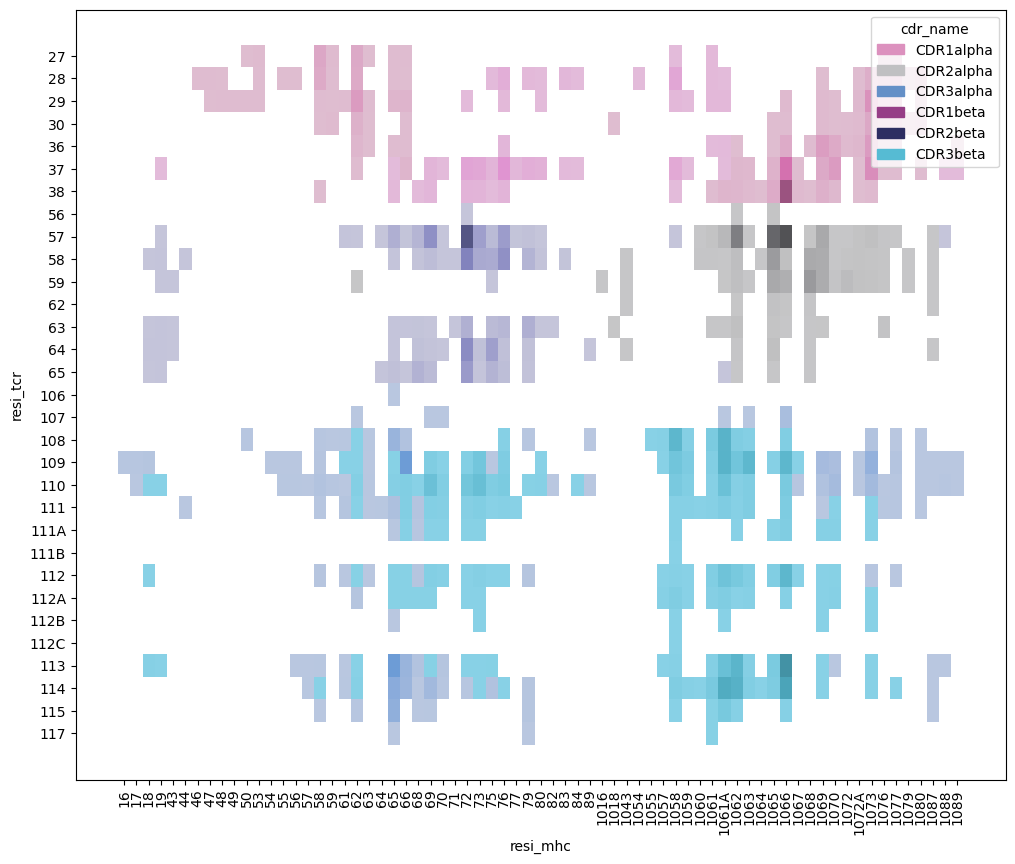

In [10]:
plt.figure(figsize=(12, 10))

sns.histplot(contacts, x='resi_mhc', y='resi_tcr', hue='cdr_name', palette=sns.color_palette(palette, 6))
plt.xticks(rotation=90)
print()

In [11]:
num_contacts = contacts.value_counts('resi_mhc')
num_contacts.name = 'number_of_tcr_contacts'
num_contacts.to_csv('../data/class_mhc_contacts_from_tcr.csv')